<a href="https://colab.research.google.com/github/Buy-me-some-str/practice/blob/main/Py_torch_02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

### Классификация Pytorch

In [3]:
#1.import data
from sklearn.datasets import make_circles

In [4]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [5]:
print("X:",X[:5], "y:",y[:5])

X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] y: [1 1 1 1 0]


In [6]:
circles = pd.DataFrame({"X1":X[:, 0], 
                        "X2":X[:, 1],
                        "label": y})

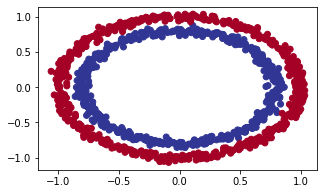

In [7]:
plt.figure(figsize=(5, 3))
plt.scatter(x=circles.X1,
            y=circles.X2,
            c=circles.label,
            cmap=plt.cm.RdYlBu)

In [8]:
#1.1 размерности
X.shape, y.shape
X.dtype

dtype('float64')

In [9]:
#1.2 тензоры
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
#1.3 разбиение
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

In [11]:
len(X_train), len(y_test)

(800, 200)

In [12]:
#2 построение модели
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [80]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=5)
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=25)
        self.layer_3 = nn.Linear(in_features=25,
                                 out_features=50)
        self.layer_4 = nn.Linear(in_features=50,
                                 out_features=1)
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        return x

In [81]:
model_0 = CircleModelV0()
model_0 = model_0.to(device)

In [82]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140],
                      [-0.2060, -0.0524, -0.1816,  0.2967, -0.3530],
                      [-0.2062, -0.1263, -0.2689,  0.0422, -0.4417],
                      [ 0.4039, -0.3799,  0.3453,  0.0744, -0.1452],
                      [ 0.2764,  0.0697,  0.3613,  0.0489, -0.1410],
                      [ 0.1202, -0.1213,  0.1882,  0.3993,  0.2585],
                      [-0.1955,  0.2582,  0.0800,  0.2271, -0.2726],
                      [-0.4427, -0.1728, -0.3430,  0.3670,  0.1288],
                      [ 0.1852,  0.1414, -0.0078,  0.350

In [83]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(untrained_preds[:5].squeeze(dim=1), y_test[:5])

tensor([0.1656, 0.1709, 0.1503, 0.1700, 0.1479], device='cuda:0') tensor([1., 0., 1., 0., 1.], device='cuda:0')


In [ ]:
#2.1 функция потерь (с автоматической сигмоидной активацией)
loss_fn = torch.nn.BCEWithLogitsLoss()
##nn.BCEWithLogitLoss() = nn.Sequential(
##      nn.Sigmoid(),
##      nn.BCELoss()
##)
#2.2 оптимизатор (SGD, Adam)
optim = torch.optim.Adam(params=model_0.parameters(),
                         lr=0.01)
#оптимизатор оптимизирует параметры из model_0.parameters()
model_0.state_dict()

In [85]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    #item() - из тензора делает число
    accuracy = (correct/len(y_pred))*100
    return accuracy
untrained_preds_probs = torch.sigmoid(untrained_preds.cpu())
accuracy_fn(y_train.cpu(), torch.round(untrained_preds_probs.cpu()))

40000.0

In [86]:
#logits_>pred_prob->label

In [87]:
#3.Тренировочный цикл
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
loss_value = []
test_loss_value = []
count_epochs = []

In [88]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [89]:
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0.forward(X_train).squeeze() #-1 измерение
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train,
                           y_pred=y_pred)
    optim.zero_grad()
    loss.backward()
    optim.step()
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_accuracy = accuracy_fn(y_true=y_test,
                                  y_pred=test_pred)
    if epoch%10==0:
        count_epochs.append(epoch)
        loss_value.append(accuracy)
        test_loss_value.append(test_accuracy)

In [90]:
with torch.inference_mode():
    test_pred_logits = model_0.forward(X_test).squeeze()

In [91]:
test_pred_probs = torch.sigmoid(test_pred_logits)
test_pred = torch.round(test_pred_probs)
X_test = X_test.to('cpu')
test_pred = test_pred.to('cpu')

In [92]:
X_test.device, test_pred.device

(device(type='cpu'), device(type='cpu'))

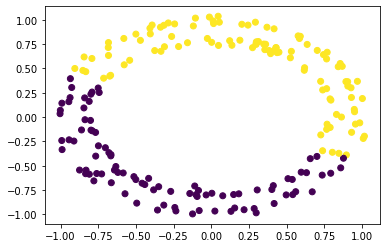

In [93]:
plt.scatter(X_test[:,0], 
            X_test[:,1], 
            c = test_pred)

In [94]:
test_pred

tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        1., 1.])

In [95]:
y_test

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.], device='cuda:0')

In [96]:
accuracy_fn(y_true=y_test.cpu(),
            y_pred=test_pred.cpu())

46.0

In [97]:
loss_fn(test_pred.cpu(), y_test.cpu())

tensor(0.7780)